In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import anndata as ad 
import scanpy as sc
sys.path.append("../../../../")
import utils
from sklearn.decomposition import PCA
import umap
import graph
import visualize
import sklearn.metrics

/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define modularity score

import leidenalg
import igraph as ig

def get_modularity(n,edges, seed = 42, resolution = 1):
    
    g = ig.Graph(directed=True)
    g.add_vertices(n)
    g.add_edges(list(zip(edges[0], edges[1])))
    g.es['weight'] = tuple(edges[2])
    partition_kwargs = {'n_iterations': -1, 'seed': seed,
                    'resolution_parameter': resolution}
    partition_kwargs['weights'] = np.array(g.es['weight']).astype(np.float64)
    partition_type = leidenalg.RBConfigurationVertexPartition
    curr_part = leidenalg.find_partition(
                graph=g, partition_type=partition_type,
                **partition_kwargs
            )
    curr_modularity = curr_part.modularity
    
    return curr_modularity

In [3]:
# read in files
snap_embed = np.load('../data/double_snap_combo_stable_binVer_0325.npy')#[:50000,:]
df = pd.read_csv('../data/features_and_metadata_withAnn.csv', index_col=0)
features_names = [
        'CD2', 'CD56',
        'CD20', 'CD30', 'CD31', 'CD4', 
        'CD57',  'CD7', 'CD8',
        'Granzyme.B','FoxP3', 'CD11c', 'CD16', 'CD206', 'CD163', 'CD68', 'CD15', 'CD11b',
        'MCT', 'Cytokeratin', 
        'Podoplanin', 'a.SMA'
    ]
features = df[features_names].to_numpy()#[:50000,:]
concact_embed = np.load("../data/nbhd_feat_concact.npy")#[:50000,:]
spice_embed = np.load("../data/spicemix_chlfull_embedding.npy")#[:50000,:]

##### load in muse 0-4 batch results
muse_embed0 = np.load("../data/muse_469full_embedding_batch_0.npy")
muse_embed1 = np.load("../data/muse_469full_embedding_batch_1.npy")
muse_embed2 = np.load("../data/muse_469full_embedding_batch_2.npy")
muse_embed3 = np.load("../data/muse_469full_embedding_batch_3.npy")
muse_embed4 = np.load("../data/muse_469full_embedding_batch_4.npy")
muse_embedll = [muse_embed0, muse_embed1, muse_embed2, muse_embed3, muse_embed4]

print([snap_embed.shape, features.shape, concact_embed.shape,
      spice_embed.shape, muse_embed0.shape])

[(143730, 32), (143730, 22), (143730, 39), (143730, 20), (10000, 30)]


In [6]:
# for loop start:
batch = 5
dflist = []
for i in range(batch):
    print('at', i)
    
    indices = np.random.choice(snap_embed.shape[0], 25000, replace=False)
    
    snap_embed_sub = snap_embed[indices]
    features_sub = features[indices]
    concact_embed_sub = concact_embed[indices]
    spice_embed_sub = spice_embed[indices]
    muse_embed_sub = muse_embedll[i]
    
    ##### calculate umap
    
    # start to calculate silhoutte score
    feature_ss_list = []
    snap_ss_list = []
    concact_ss_list = []
    spice_ss_list = []
    muse_ss_list = []
    
    ## feature edges
    feature_edges = graph.get_feature_edges(
        arr=features_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## snap
    snap_edges = graph.get_feature_edges(
        arr=snap_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## concact 
    concact_edges = graph.get_feature_edges(
        arr=concact_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## muse 
    muse_edges = graph.get_feature_edges(
        arr=muse_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    ## spice 
    spice_edges = graph.get_feature_edges(
        arr=spice_embed_sub, pca_components=None,
        n_neighbors=15, metric='correlation', verbose=False
    )

    res_list = [round(x, 2) for x in np.arange (0.4, 2.6, 0.2)]
    for res in res_list:
        
        feature_ss = get_modularity(features_sub.shape[0], feature_edges, resolution = res)
        snap_ss = get_modularity(snap_embed_sub.shape[0], snap_edges, resolution = res)
        concact_ss = get_modularity(concact_embed_sub.shape[0], concact_edges, resolution = res)
        spice_ss = get_modularity(spice_embed_sub.shape[0], spice_edges, resolution = res)
        muse_ss = get_modularity(muse_embed_sub.shape[0], muse_edges, resolution = res)
        
        feature_ss_list.append(feature_ss)
        snap_ss_list.append(snap_ss)
        concact_ss_list.append(concact_ss)
        spice_ss_list.append(spice_ss)
        muse_ss_list.append(muse_ss)
        
    data = {'res':res_list, 'ch_feature':feature_ss_list,
            'ch_snap':snap_ss_list,'ch_concact':concact_ss_list,
           'ch_spice':spice_ss_list, 'ch_muse':muse_ss_list}
    
    df = pd.DataFrame(data)
    df['batch'] = i
    dflist.append(df)
    


at 0
at 1
at 2
at 3
at 4


/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bokai/miniconda3/envs/cellsnap/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


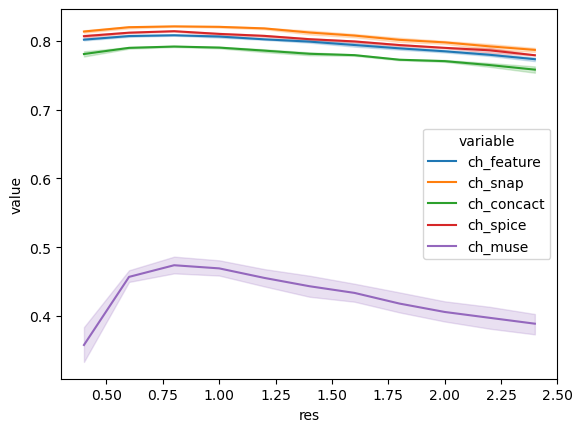

In [7]:
test = pd.concat(dflist)
test2 = test.melt(id_vars=['res'], value_vars=['ch_feature', 'ch_snap', 'ch_concact', 'ch_spice', 'ch_muse'])
test2.to_csv('../data/Mod_result_chlcdxfull_0325.csv')

plot = sns.lineplot(data=test2,x="res", y="value", hue="variable")
fig = plot.get_figure()
#fig.savefig('../plots/CH_allmethods_dbGNNstab.svg', dpi = 300) 
